<a href="https://colab.research.google.com/github/ralph27/ZAKA-hands-on/blob/master/Improving_DL_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced concepts
© 2024, Zaka AI, Inc. All Rights Reserved.

---



**Objective:** The goal of this notebook is to go over the advanced concepts that were discussed in the chapter and see them in action.

Each block will cover a different concept and blocks are not related.

The required libraries for this exercise are `Keras` for building and training the DL model, `Numpy` for numerical handling and loading of the dataset and `scikit-learn` for validation and datasplit.

##Load Data

## Save / Load models

Training deep learning models can take a lot of time, depending on the size of the network and the dataset used for training. It can be beneficial to save a copy of the network while training, so we can resume later on if anything happens.

Keras provides us with functions that allows us to serialize a model to JSON format and to save its weights in HDF5 format. When saving the model as a JSON file, we’re only saving the network’s architecture and not the weights.

Similarly, we can load a model from disk my calling the model_from_json() function and we can load the weights by calling load_weights() function.

### Train model and save it to disk

In this example, we will create a Keras sequential model, fit this model on the [Credit Card Fraud Fraud Detection 2023 dataset](https://www.kaggle.com/datasets/nelgiriyewithana/credit-card-fraud-detection-dataset-2023), then serialize the model to JSON format and save it along with the weights on the disk.

We will later see how we can load the model from disk, apply the weights and resume work as normal.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import model_from_json
import pandas as pd
import numpy

# load the dataset
dataframe = pd.read_csv("/content/drive/MyDrive/creditcard_2023.csv")
dataframe.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder


# Separate Y (last column) and X (all columns except the last one)
Y = dataframe.iloc[:, -1]
X = dataframe.iloc[:, :-1]

# create Sequential model
model = Sequential()
model.add(Dense(1024, input_dim=30, activation='relu'))

model.add(Dense(512, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

# Compile model using Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model.fit(X, Y, epochs=10, batch_size=512)

# evaluate the model on training data
scores = model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Epoch 1/10
1111/1111 [==============================] - 6s 4ms/step - loss: 631.2176 - accuracy: 0.7294
Epoch 2/10
1111/1111 [==============================] - 4s 3ms/step - loss: 79.3519 - accuracy: 0.7520
Epoch 3/10
1111/1111 [==============================] - 4s 4ms/step - loss: 13.9449 - accuracy: 0.8286
Epoch 4/10
1111/1111 [==============================] - 5s 4ms/step - loss: 5.9644 - accuracy: 0.8842
Epoch 5/10
1111/1111 [==============================] - 4s 3ms/step - loss: 4.1700 - accuracy: 0.9063
Epoch 6/10
1111/1111 [==============================] - 4s 4ms/step - loss: 1.1891 - accuracy: 0.9477
Epoch 7/10
1111/1111 [==============================] - 5s 4ms/step - loss: 1.6258 - accuracy: 0.9297
Epoch 8/10
1111/1111 [==============================] - 4s 3ms/step - loss: 0.6767 - accuracy: 0.9476
Epoch 9/10
1111/1111 [==============================] - 4s 3ms/step - loss: 0.2355 - accuracy: 0.9746
Epoch 10/10
1111/1111 [==============================] - 4s 4ms/step - loss: 0

### Load model from disk and use it

After the model was serialized to JSON format and saved on the disk, we can use the `model_from_json` function to load the model's architecture again and then load the weights using `load_weights` function.

Once the model's topology is defined and the weights are loaded, we can use the model for evaluation but we have to make sure to compile it first!

In [ ]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

# don't forget to compile the model!
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# evaluate loaded model on training data
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 99.11%


##Keras Callbacks

A callback is a function to be applied at given stages of the training procedure.
Get a view on internal states and statistics of the model during training.
You can pass a list of callbacks to the .fit() method.
The relevant methods of the callbacks will then be called at each stage of the training.


## Checkpoint Neural Network Model Improvements

The first callback function we’ll look at today is the Model Checkpoint callback. This callback saves the model after every epoch.
Let's start by importing the necessary libraries, and then splitting the data into input variables (X) and output variable (Y).

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy

dataframe = pd.read_csv("/content/drive/MyDrive/creditcard_2023.csv")
Y = dataframe.iloc[:, -1]
X = dataframe.iloc[:, :-1]

Let's define a `create_model` function to create and return the model.


In [ ]:
def create_model():
  model = Sequential()
  model.add(Dense(1024, input_dim=30, activation='relu'))

  model.add(Dense(512, activation='relu'))

  model.add(Dense(1, activation='sigmoid'))

  # Compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

Initialize the ModelCheckpoint callback and pass it to the `model.fit()` function

In [ ]:
# define the checkpoint's name that includes the index of the epoch and the validation accuracy
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"

# create an instance of ModelCheckpoint
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# create the model
model = create_model()

# fit the model with the callbacks list
model.fit(X, Y, validation_split=0.33, epochs=10, batch_size=512, callbacks=callbacks_list, verbose=0)



Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to weights-improvement-01-1.00.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy did not improve from 1.00000

Epoch 3: val_accuracy did not improve from 1.00000

Epoch 4: val_accuracy did not improve from 1.00000

Epoch 5: val_accuracy did not improve from 1.00000

Epoch 6: val_accuracy did not improve from 1.00000

Epoch 7: val_accuracy did not improve from 1.00000

Epoch 8: val_accuracy did not improve from 1.00000

Epoch 9: val_accuracy did not improve from 1.00000

Epoch 10: val_accuracy did not improve from 1.00000


## Checkpoint Best Neural Network Model Only

Instead of saving a new copy of the model every time the monitored value improves, we can save only 1 model checkpoint by specifying a fixed name for the checkpoint.

In [ ]:
# fixed checkpoint name
filepath="weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# create the model
model = create_model()

# fit the model
model.fit(X, Y, validation_split=0.33, epochs=10, batch_size=512, callbacks=callbacks_list, verbose=0)


Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to weights_best.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy did not improve from 1.00000

Epoch 3: val_accuracy did not improve from 1.00000

Epoch 4: val_accuracy did not improve from 1.00000

Epoch 5: val_accuracy did not improve from 1.00000

Epoch 6: val_accuracy did not improve from 1.00000

Epoch 7: val_accuracy did not improve from 1.00000

Epoch 8: val_accuracy did not improve from 1.00000

Epoch 9: val_accuracy did not improve from 1.00000

Epoch 10: val_accuracy did not improve from 1.00000


## Load and use weights from a checkpoint

Now that we have saved the best model weights, let's see how we can load and re-use them.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy

# create model with same architecture!
model = Sequential()
model.add(Dense(1024, input_dim=30, activation='relu'))

model.add(Dense(512, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

# load best weights
model.load_weights("weights_best.hdf5")

# compile model (required to make predictions)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Created model and loaded weights from file")


# estimate accuracy on whole dataset using loaded weights
scores = model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


Created model and loaded weights from file
accuracy: 76.67%


## Visualize model training history

Another concept discussed in this lesson is the model training history. When calling the `model.fit()` function, we can retrieve the training history and use that to visualize the training process.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


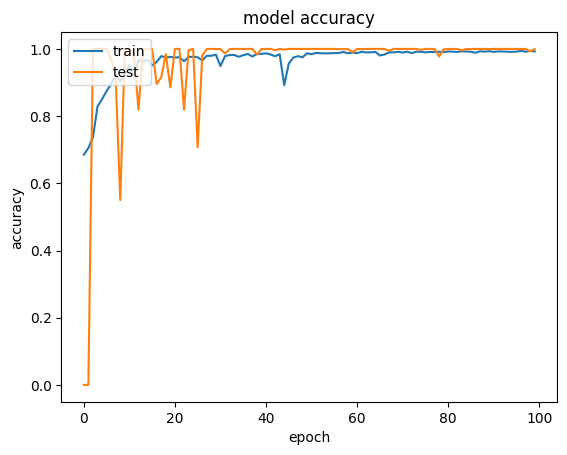

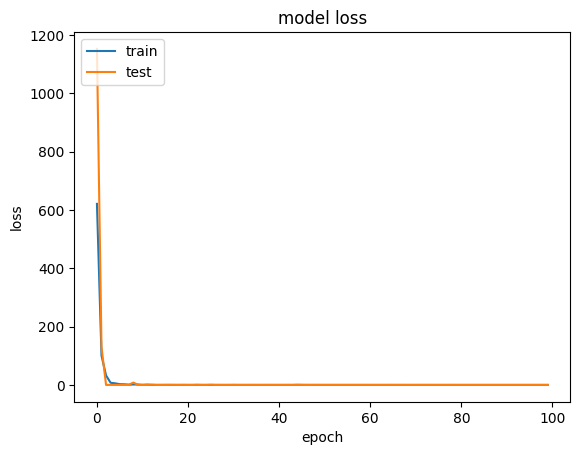

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import numpy

dataframe = pd.read_csv("/content/drive/MyDrive/creditcard_2023.csv")
Y = dataframe.iloc[:, -1]
X = dataframe.iloc[:, :-1]

# create model
model = Sequential()
model.add(Dense(1024, input_dim=30, activation='relu'))

model.add(Dense(512, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model and retrieve the training history
training_history = model.fit(X, Y, validation_split=0.33, epochs=100, batch_size=512, verbose=0)

# list all data in history
print(training_history.history.keys())

# summarize history for training and validation accuracy
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for training and validation loss
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


##Introducing Dropouts

Dropouts can help the model generalize better, and would help reduce falling in the overfitting trap.

For this purpose, we will now add some dropout layers and see their effect on the results we would obtain.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt
import numpy

dataframe = pd.read_csv("/content/drive/MyDrive/creditcard_2023.csv")
Y = dataframe.iloc[:, -1]
X = dataframe.iloc[:, :-1]

# create model
model = Sequential()
model.add(Dense(1024, input_dim=30, activation='relu'))
model.add(Dropout(rate = 0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate = 0.1))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model and retrieve the training history
model.fit(X, Y, validation_split=0.33, epochs=20, batch_size=512, verbose=1)

# evaluate the model on training data
scores = model.evaluate(X, Y, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/20
745/745 [==============================] - 5s 5ms/step - loss: 249.2933 - accuracy: 0.7276 - val_loss: 0.7618 - val_accuracy: 0.0000e+00
Epoch 2/20
745/745 [==============================] - 3s 5ms/step - loss: 0.4611 - accuracy: 0.7834 - val_loss: 0.5009 - val_accuracy: 0.9893
Epoch 3/20
745/745 [==============================] - 4s 6ms/step - loss: 0.4266 - accuracy: 0.7916 - val_loss: 1.3188 - val_accuracy: 0.0000e+00
Epoch 4/20
745/745 [==============================] - 4s 5ms/step - loss: 0.4138 - accuracy: 0.7987 - val_loss: 0.1024 - val_accuracy: 1.0000
Epoch 5/20
745/745 [==============================] - 3s 4ms/step - loss: 0.4174 - accuracy: 0.8153 - val_loss: 0.3029 - val_accuracy: 1.0000
Epoch 6/20
745/745 [==============================] - 3s 5ms/step - loss: 0.3789 - accuracy: 0.8318 - val_loss: 1.2012 - val_accuracy: 0.0000e+00
Epoch 7/20
745/745 [==============================] - 5s 6ms/step - loss: 0.3523 - accuracy: 0.8607 - val_loss: 0.1448 - val_accuracy:

We see that the performance of our model increases.